# Visualising MESSENGER Region Probability Maps

This notebook generates a multi-panel figure showing probability maps constructed from
MESSENGER region observations. This is a walkthrough of the script contained in `src/figure-creation/figure1_probability_maps.py`

The final figure contains four panels:

1. **MESSENGER Residence Time** (hours spent in each spatial bin)
2. **Solar Wind probability**
3. **Magnetosheath probability**
4. **Magnetosphere probability**

In [1]:
import os
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from hermpy.utils import Constants
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle

## Input and Output Files
The probability maps (created by `src/create_probabilitiy_maps.py`) are stored in a NetCDF file:
- `resources/region_probability_maps.nc`

Check that the below paths are correct before continuing!

In [8]:
# Adjust this if needed (e.g., Path("..") if notebook is inside a subfolder)
PROJECT_ROOT = Path("../..")

PROBABILITIY_MAPS_FILE = PROJECT_ROOT / "resources/region_probability_maps.nc"
FIG_OUTPUT = PROJECT_ROOT / "figures/figure1.pdf"

PROBABILITIY_MAPS_FILE, FIG_OUTPUT

(PosixPath('../../resources/region_probability_maps.nc'),
 PosixPath('../../figures/figure1.pdf'))

## Helper Functions

In [ ]:
def draw_alternating_circle(center, radius, ax, segments=200, linewidth=3, **kwargs):
    """
    Draw a circle on a Matplotlib axis using alternating black/white line segments.

    This is used to visually represent Mercury's boundary with a distinctive
    alternating pattern.

    Parameters
    ----------
    center : tuple[float, float]
        (x, y) center of the circle in data coordinates.
    radius : float
        Circle radius in data units.
    ax : matplotlib.axes.Axes
        Axis to draw onto.
    segments : int, default=200
        Number of segments used to approximate the circle. More segments gives
        a smoother circle.
    linewidth : float, default=3
        Width of the circle segments.
    **kwargs
        Additional keyword arguments passed to `matplotlib.collections.LineCollection`.
    """
    x0, y0 = center

    theta = np.linspace(0, 2 * np.pi, segments)
    x = x0 + radius * np.cos(theta)
    y = y0 + radius * np.sin(theta)

    points = np.column_stack((x, y))
    segments_list = np.stack([points[:-1], points[1:]], axis=1)

    colors = ["black" if i % 2 == 0 else "white" for i in range(len(segments_list))]

    lc = LineCollection(segments_list, colors=colors, linewidths=linewidth, **kwargs)
    ax.add_collection(lc)


class CurvedLegendHandle:
    """
    Custom legend handle that draws a curved arc symbol inside a Matplotlib legend.

    This is used to create a legend entry representing the curved Mercury boundary
    marker drawn in the panels.
    """

    def __init__(self, angle=180):
        """
        Parameters
        ----------
        angle : float, default=180
            Reserved for potential customization of the arc curvature/extent.
            (Currently the arc is drawn from 0 to 180 degrees.)
        """
        self.angle = angle

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        """
        Matplotlib hook to draw the custom legend artist.

        Returns
        -------
        matplotlib.patches.Arc
            The arc artist added to the legend handle box.
        """
        w, h = handlebox.width, handlebox.height
        x, y = handlebox.xdescent, handlebox.ydescent

        arc = mpatches.Arc(
            (x + w / 2, y + h / 2),
            w,
            h * 2,
            angle=0,
            theta1=0,
            theta2=180,
            lw=2,
            ls=(0, (2, 2)),
            color="black",
            transform=handlebox.get_transform(),
        )

        handlebox.add_artist(arc)
        return arc

## Load Probability Maps Dataset

We load the NetCDF dataset using `xarray`.

The dataset is expected to contain variables such as:

- `"Minutes In Bin"` (used for residence time)
- `"Solar Wind"`
- `"Magnetosheath"`
- `"Magnetosphere"`

Each variable is defined over a spatial grid using coordinates:

- `"X MSM'"`
- `"CYL MSM'"`

We will plot these on a shared set of axes.

You will see lots of nan values in this dataset. They correspond to bins unexplored by MESSENGER.

In [9]:
probability_maps = xr.load_dataset(PROBABILITIY_MAPS_FILE)
probability_maps

<xarray.Dataset> Size: 113kB
Dimensions:                  (X MSM': 40, CYL MSM': 32)
Coordinates:
  * X MSM'                   (X MSM') float64 320B -4.875 -4.625 ... 4.625 4.875
  * CYL MSM'                 (CYL MSM') float64 256B 0.125 0.375 ... 7.625 7.875
Data variables:
    Magnetosheath            (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere            (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Solar Wind               (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Minutes In Bin           (X MSM', CYL MSM') float64 10kB 0.0 0.0 ... 0.0 0.0
    N Observations           (X MSM', CYL MSM') float64 10kB 0.0 0.0 ... 0.0 0.0
    Solar Wind 95% Lower     (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Solar Wind 95% Upper     (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosheath 95% Lower  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosheath 95% Upper  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere 95% Lower  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan
    Magnetosphere 95% Upper  (X MSM', CYL MSM') float64 10kB nan nan ... nan nan

## Plotting

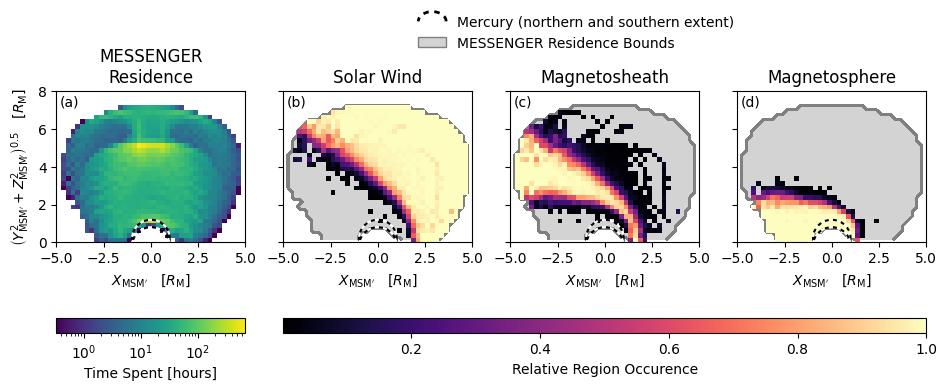

In [24]:
# Ensure output directory exists
FIG_OUTPUT.parent.mkdir(parents=True, exist_ok=True)

# Create the figure and 4 side-by-side panels
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 4))

# ----------------------------
# Panel (a): Residence time
# ----------------------------

# Convert residence time from minutes to hours
residence_data = probability_maps["Minutes In Bin"] / 60

# Plot residence time using a log scale to show both low and high coverage areas
residence_mesh = axes[0].pcolormesh(
    residence_data.coords["X MSM'"],
    residence_data.coords["CYL MSM'"],
    residence_data.values.T,
    cmap="viridis",
    norm="log",
)

# Create a mask showing where the spacecraft has any residence time at all
residence_mask = residence_data.values.T != 0

# Configure residence panel
axes[0].set_title("MESSENGER\nResidence")

# Add a colorbar below the residence panel
cbar_bounds = [0, -0.6, 1, 0.1]
cbar_ax = axes[0].inset_axes(cbar_bounds)
plt.colorbar(
    residence_mesh,
    cax=cbar_ax,
    location="bottom",
    label="Time Spent [hours]",
)

# Y-axis label for the first panel only
axes[0].set_ylabel(
    r"$\left(Y_{\rm MSM'}^2 + Z_{\rm MSM'}^2 \right)^{0.5}\quad \left[ R_{\rm M} \right]$"
)

# ----------------------------
# Panels (b-d): Region maps
# ----------------------------

regions = ["Solar Wind", "Magnetosheath", "Magnetosphere"]

for i, ax in enumerate(axes[1:]):
    # Select region probability map
    map_data = probability_maps[regions[i]]

    # Hide zeros so unobserved regions don't appear as true 0 probability
    map_data.values[np.where(map_data.values == 0)] = np.nan

    # Plot region probability (0 to 1)
    mesh = ax.pcolormesh(
        map_data.coords["X MSM'"],
        map_data.coords["CYL MSM'"],
        map_data.values.T,
        vmax=1,
        cmap="magma",
    )

    # Draw the outline of MESSENGER residence coverage
    ax.contour(
        map_data.coords["X MSM'"],
        map_data.coords["CYL MSM'"],
        residence_mask,
        levels=[0.5],
        antialiased=False,
        colors="grey",
        zorder=-1,
    )

    # Shade outside residence coverage in light grey
    ax.contourf(
        map_data.coords["X MSM'"],
        map_data.coords["CYL MSM'"],
        residence_mask,
        levels=[0, 0.5, 1],
        colors=["white", "lightgrey"],
        zorder=-2,
    )

    # Title each region panel
    ax.set_title(regions[i])

    # Add a shared region probability colorbar under the middle region panel
    if i == 1:
        cbar_bounds = [-1.2, -0.6, 3.4, 0.1]
        cbar_ax = ax.inset_axes(cbar_bounds)
        plt.colorbar(
            mesh,
            cax=cbar_ax,
            location="bottom",
            label="Relative Region Occurence",
        )

# ----------------------------
# Shared axis formatting
# ----------------------------

labels = ["a", "b", "c", "d"]

for i, ax in enumerate(axes):
    # Ensure equal scaling for x/y to preserve geometry
    ax.set_aspect("equal")

    # Set consistent axis limits across all panels
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 8)

    # Shared x-axis label
    ax.set_xlabel(r"$X_{\rm MSM'} \quad \left[ R_{\rm M} \right]$")

    # Draw Mercury boundaries (north/south extent) using alternating circle segments
    mercury_params = {"segments": 30, "linewidth": 1.5}

    draw_alternating_circle(
        (0, Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS),
        1,
        ax,
        **mercury_params,
    )
    draw_alternating_circle(
        (0, -(Constants.DIPOLE_OFFSET / Constants.MERCURY_RADIUS)),
        1,
        ax,
        **mercury_params,
    )

    # Add panel label in axes coordinates
    ax.text(0.02, 0.9, f"({labels[i]})", transform=ax.transAxes)

# ----------------------------
# Custom legend
# ----------------------------

custom_handles = [
    CurvedLegendHandle(angle=180),
    Rectangle((0, 0), 1, 1, facecolor="lightgrey", edgecolor="grey"),
]

fig.legend(
    custom_handles,
    ["Mercury (northern and southern extent)", "MESSENGER Residence Bounds"],
    loc="upper center",
    ncol=1,
    frameon=False,
    handler_map={CurvedLegendHandle: custom_handles[0]},
    bbox_to_anchor=(0.6, 0.95),
)

# Adjust spacing and save
fig.subplots_adjust(left=0.08, right=0.95, bottom=0.2)

# Show the figure inline
plt.show()
